In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from linearmodels.panel import PanelOLS
import statsmodels.formula.api as smf

# DGP

$t \in \{1,2,3,4\}$

$N=100$

$d = \mathbb{1}\big(i \in Sample(50, \text{1 to N})\big)$

Simulate covariates with non parallel trends

$XS_{i} \sim N(0,1)$

$X_{it} = 0.2 t * XS_{i}$

$FE_i \sim N(0,1)$


Treatment effect **with heterogeneity** in X

$Y_{0,it} = 0.5 t + FE_i + X_{it}$

$Y_{1,it} = Y_{0,it} + 1$

$\tau_{it} = 1$

$Y_{it} = (1-\mathbb{1}_{t>2} d_i) Y_{0,it} + (\mathbb{1}_{t>2} d_i) Y_{1,it}$

In [15]:
time = range(1, 4+1)
time_t = 3
units = range(1, 50+1)
treat_prop = 0.5

np.random.seed(123)

df = pd.DataFrame(dict(
    time = np.tile(time, len(units)),
    unit = np.repeat(units, len(time)),
    unit_fe = np.repeat(np.random.normal(size=len(units)), len(time)),
    time_fe = np.tile(np.random.normal(size=len(time)), len(units)),
    x = np.repeat(np.random.normal(0, 1, size=len(units)), len(time)),
)).assign(
    post = lambda d: (d["time"] >= time_t).astype(int),
    treat = lambda d: (np.random.normal(d["x"]) > 0).astype(int),
    y0 = lambda d: d["time"]/2 + d["time"]*d["x"] + d["time_fe"] + d["unit_fe"] + d["x"],
    y1 = lambda d: d["time"]/2 + d["time"]*d["x"] + d["time_fe"] + d["unit_fe"] + d["x"] + 1
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    y = lambda d: np.where(d["post"] * d["treat"] == 1, d["y1"], d["y0"])
)

df.head(10)

,time,unit,unit_fe,time_fe,x,post,treat,y0,y1,tau,y
0,1,1,-1.085631,-1.294085,0.029683,0,1,-1.820349,-0.820349,1.0,-1.820349
1,2,1,-1.085631,-1.038788,0.029683,0,1,-1.035369,-0.035369,1.0,-1.035369
2,3,1,-1.085631,1.743712,0.029683,1,1,2.276815,3.276815,1.0,3.276815
3,4,1,-1.085631,-0.798063,0.029683,1,0,0.264723,1.264723,1.0,0.264723
4,1,2,0.997345,-1.294085,1.069316,0,1,2.341892,3.341892,1.0,2.341892
5,2,2,0.997345,-1.038788,1.069316,0,0,4.166505,5.166505,1.0,4.166505
6,3,2,0.997345,1.743712,1.069316,1,1,8.518322,9.518322,1.0,9.518322
7,4,2,0.997345,-0.798063,1.069316,1,1,7.545863,8.545863,1.0,8.545863
8,1,3,0.282978,-1.294085,0.890706,0,1,1.270306,2.270306,1.0,1.270306
9,2,3,0.282978,-1.038788,0.890706,0,1,2.916309,3.916309,1.0,2.916309


In [16]:
df.groupby("treat")["x"].mean()

treat
0   -0.655387
1    0.856639
Name: x, dtype: float64

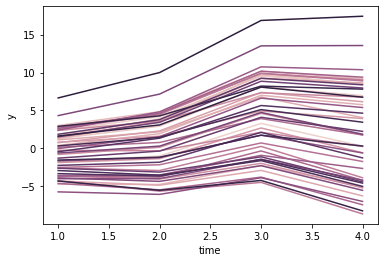

In [17]:
sns.lineplot(data=df.groupby(["time", "unit"])[["y"]].mean().reset_index(),
             x="time",
             y="y",
             hue="unit", 
             legend=None);

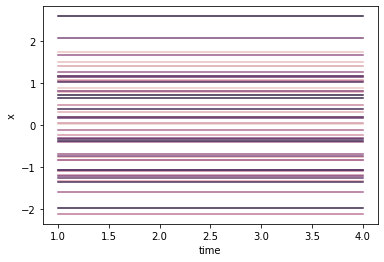

In [18]:
sns.lineplot(data=df.groupby(["time", "unit"])[["x"]].mean().reset_index(),
             x="time",
             y="x",
             hue="unit", 
             legend=None);

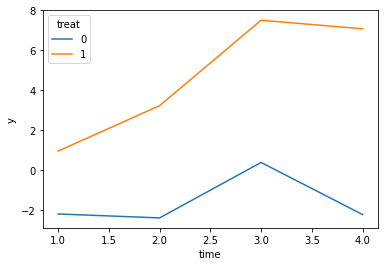

In [19]:
sns.lineplot(data=df.groupby(["time", "treat"])[["y"]].mean().reset_index(),
             x="time",
             y="y",
             hue="treat");

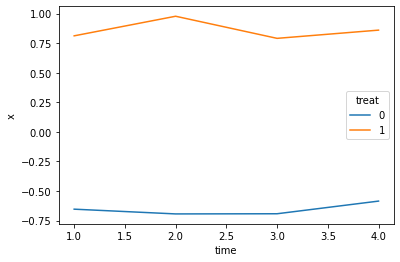

In [20]:
sns.lineplot(data=df.groupby(["time", "treat"])[["x"]].mean().reset_index(),
             x="time",
             y="x",
             hue="treat");

In [21]:
df.query("treat==1 & post==1")["tau"].mean()

1.0

In [22]:
formula = f"""y ~ treat:post + C(unit) + C(time)"""

mod = smf.ols(formula, data=df)

result = mod.fit()

result.params["treat:post"]

3.2447111020918253

In [23]:
formula = f"""y ~ treat:post + x + C(unit) + C(time)"""

mod = smf.ols(formula, data=df)

result = mod.fit()

result.params["treat:post"]

3.2447111020918094

In [27]:
formula = f"""y ~ treat:post + C(unit) + C(time)"""

mod = smf.ols(formula, data=df)

result = mod.fit()

result.params["treat:post"]

0.9999999999999968